In [6]:
import numpy as np
import matplotlib.pyplot as plt
from tqdm import tqdm
import h5py
from sklearn.svm import SVC

import multiprocessing as mp
from sklearn.neighbors import KernelDensity
from sklearn.model_selection import GridSearchCV
from sklearn import preprocessing

from IPython.display import display, Latex

%matplotlib inline
%config InlineBackend.figure_format='retina'
#!pip install git+https://github.com/M-Bianchi/My_matplotlib_style
plt.style.use('mystyle')

### Time to get your hands dirty! Can a computer learn if we're going to detect gravitational waves?

This episode of "time to get your hands dirty" is about something I studied carefully in the past: gravitational-wave selection effects. This is one the LIGO interferometers:

![](https://www.ligo.caltech.edu/system/news_items/images/53/page/Virgo_aerial_view_01.jpg?1506530275)


All experiments have selection effects. Some sources are easier to detect than others which distorts the population of sources we observe (this crucial in astronomy! Surveys are typically flux limited). 
In order to decided if a feature in the observed population of objects is telling us something new about reality, we need to understand and model our selection effects (for instance: it would be wrong to say that all stars are close by just because we can't observe those that are very far!). In observational astronomy, this is known as [Malmquist bias](https://en.wikipedia.org/wiki/Malmquist_bias) and was first formulated in 1922.
 
**The goal here is to machine-learn the LIGO detectability: can we *predict* if a gravitational-wave source will be detected?**  

[This dataset](https://github.com/dgerosa/pdetclassifier/releases/download/v0.2/sample_2e7_design_precessing_higherordermodes_3detectors.h5) contains simulated gravitational-wave signals from merging black holes (careful the file size is >1 GB). If you've never seen them, the [.h5 format](https://en.wikipedia.org/wiki/Hierarchical_Data_Format) is a highly optimized storage strategy for large datasets. It's amazing. In python, you can read it with `h5py`.

In particular, each source has the following features:
- `mtot`: the total mass of the binary
- `q`: the mass ratio
- `chi1x`, `chi1y`, `chi1z`, `chi2x`, `chi2y`, `chi2z`: the components of the black-hole spins in a suitable reference frame.
- `ra`, `dec`: the location of the source in the sky
- `iota`: the inclination of the orbital plane'
- `psi`: the polarization angle (gravitational waves have two polarization states much like light)
- `z`: the redshift

The detectability is defined using the `snr` (signal-to-noise ratio) computed with a state-of-the-art model of the LIGO/Virgo detector network. Some (many?) of you will have studied this in Sesana's gravitational-wave course; [see here](https://arxiv.org/abs/1908.11170) for a nice write-up. All you need to know now is that we threshold the `snr` values and assume that LIGO will (not) see a source if `snr`>12 (`snr`<12). The resulting 0-1 labels are reported in the `det` attribute in the dataset.

Today's task is to train a classifier (you decide which one!) and separate sources that are detectables from those that aren't. 

Be creative! This is a challenge! Let's see who gets the  higher completeness and/or the smaller contamination (on a validation set, of course! Careful with overfitting here!).

*Tips*:
- You can downsample the data for debugging purposes
- You can also use only some of the features.

### The best I could do...

Together with Alberto Vecchio and Geraint Prattent, I tackled this classification problem with neural networks: [arXiv:2007.06585](https://arxiv.org/abs/2007.06585). Next time we look into deep learning.

In the paper we reached an accuracy (true positive + true negative / total) of $98.4\%$. The data you're using are those of the green curve in Fig 2 of that paper. Could you do better? If yes, please tell me how!

I should have really put a figure with my ROC in that paper but I didn't! Deep learning people liked the accuracy and I just went with the flow.


### Another idea

Here are other ideas that I haven't explored in a paper (yet?). 

- Using the same data, we could run a regressor on `snr` instead of a classifier on `det`. We can then threshold the predictions (instead of tresholding the data like we're doing now). Would this give a better performance?

- How about trying to reduce the dimensionality of the dataset with a PCA-type algorithm to ease the classification problem?

Please let me know if you give it a try and what you find! 




# Code

## 1) Extracting the data

In [7]:
f = h5py.File('sample_2e7_design_precessing_higherordermodes_3detectors.h5')
keys = list(f.keys())
print(f'keys: {keys}')
print(f['snr'].shape)

keys: ['chi1x', 'chi1y', 'chi1z', 'chi2x', 'chi2y', 'chi2z', 'dec', 'det', 'iota', 'mtot', 'psi', 'q', 'ra', 'snr', 'z']
(20000000,)


In [8]:
cutoff = int(1e4)
#cutoff = len(f['snr'])

data = np.zeros(shape=(len(keys), cutoff))
for i in tqdm(range(len(keys))):
    data[i] = np.array(f[keys[i]])[:cutoff]

f = []
data = dict(zip(keys, data))

100%|██████████| 15/15 [00:30<00:00,  2.02s/it]


## 2) Exploring the data

### 2.1) mtot(z)

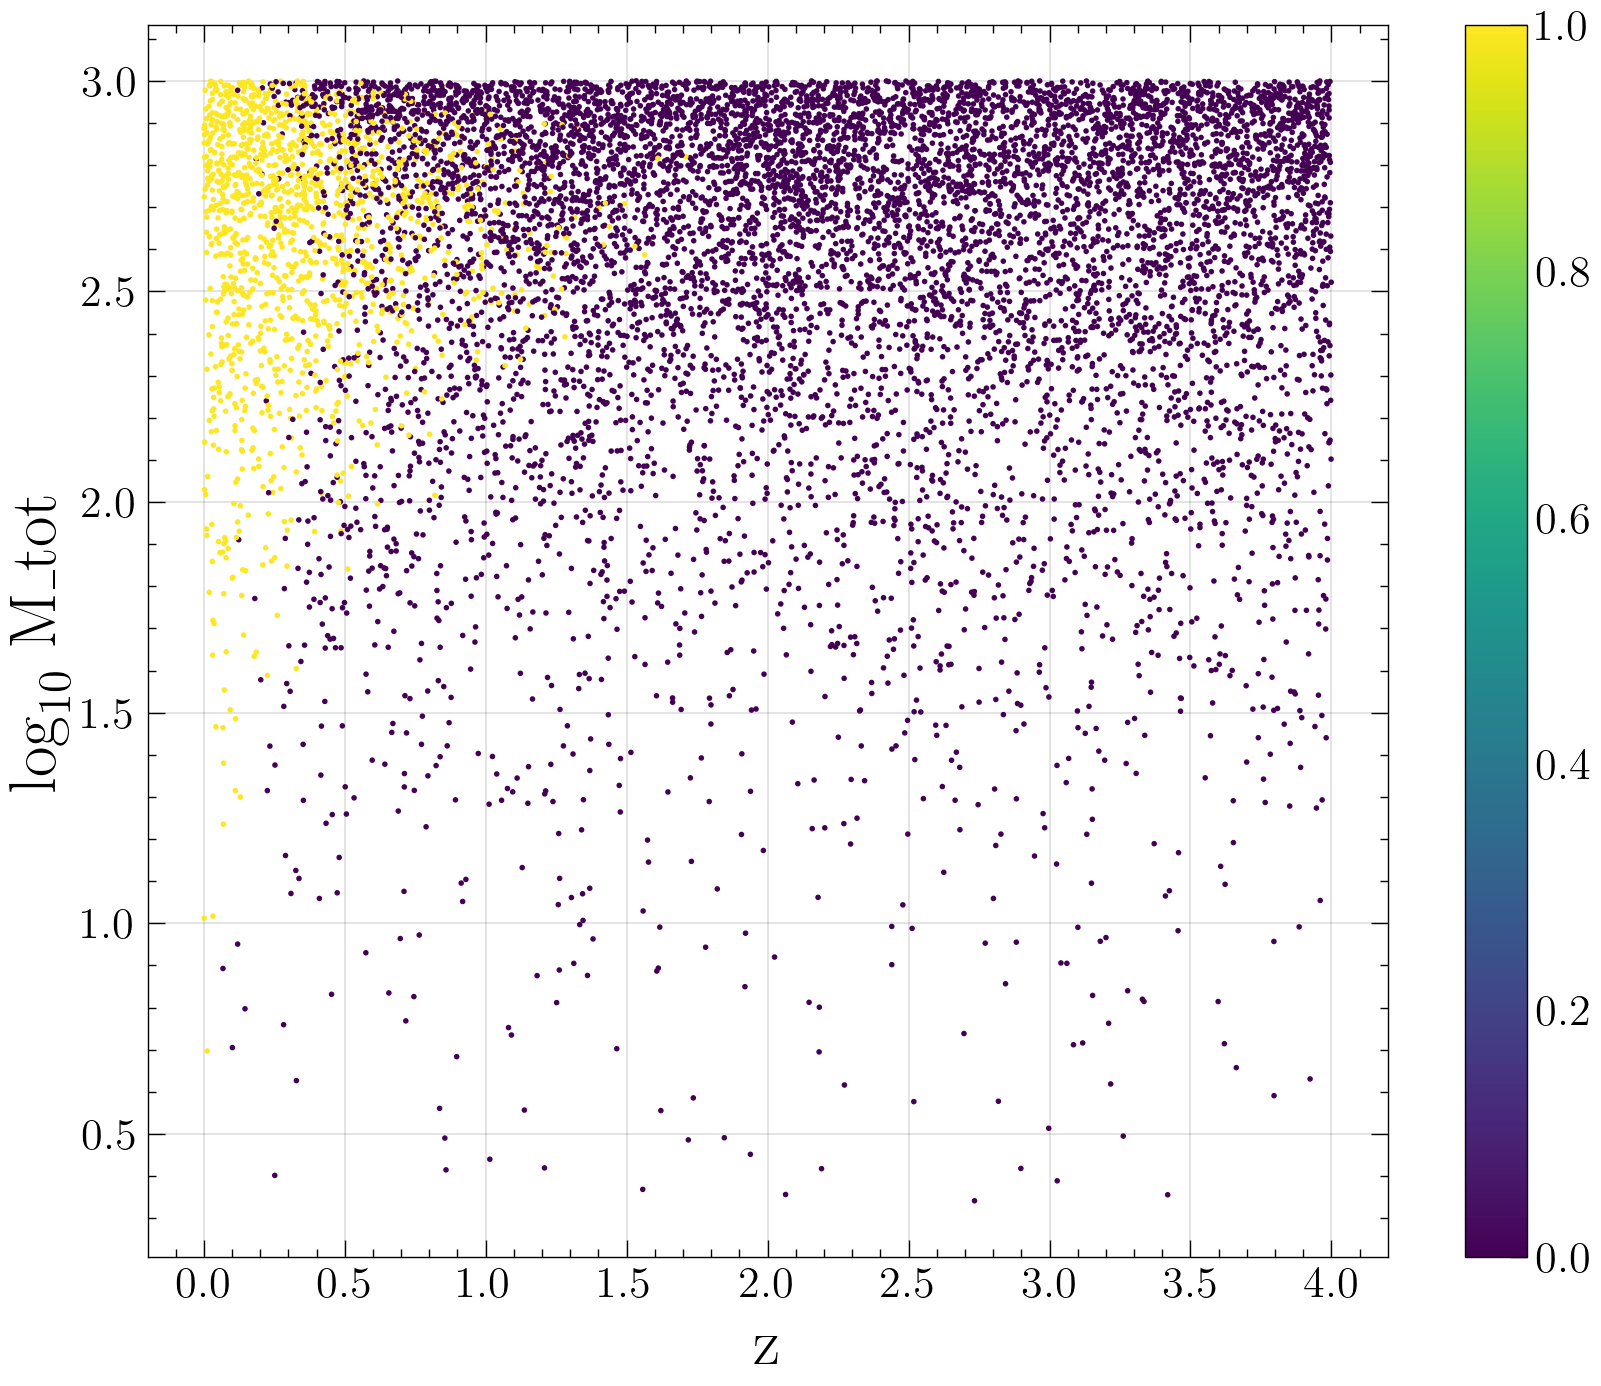

In [9]:
plt.scatter(data['z'], np.log10(data['mtot']), s=1, c=data['det'])
plt.xlabel('z')
plt.ylabel('$\log_{10}$ M_tot')
plt.colorbar();

### 2.2) iota(z)

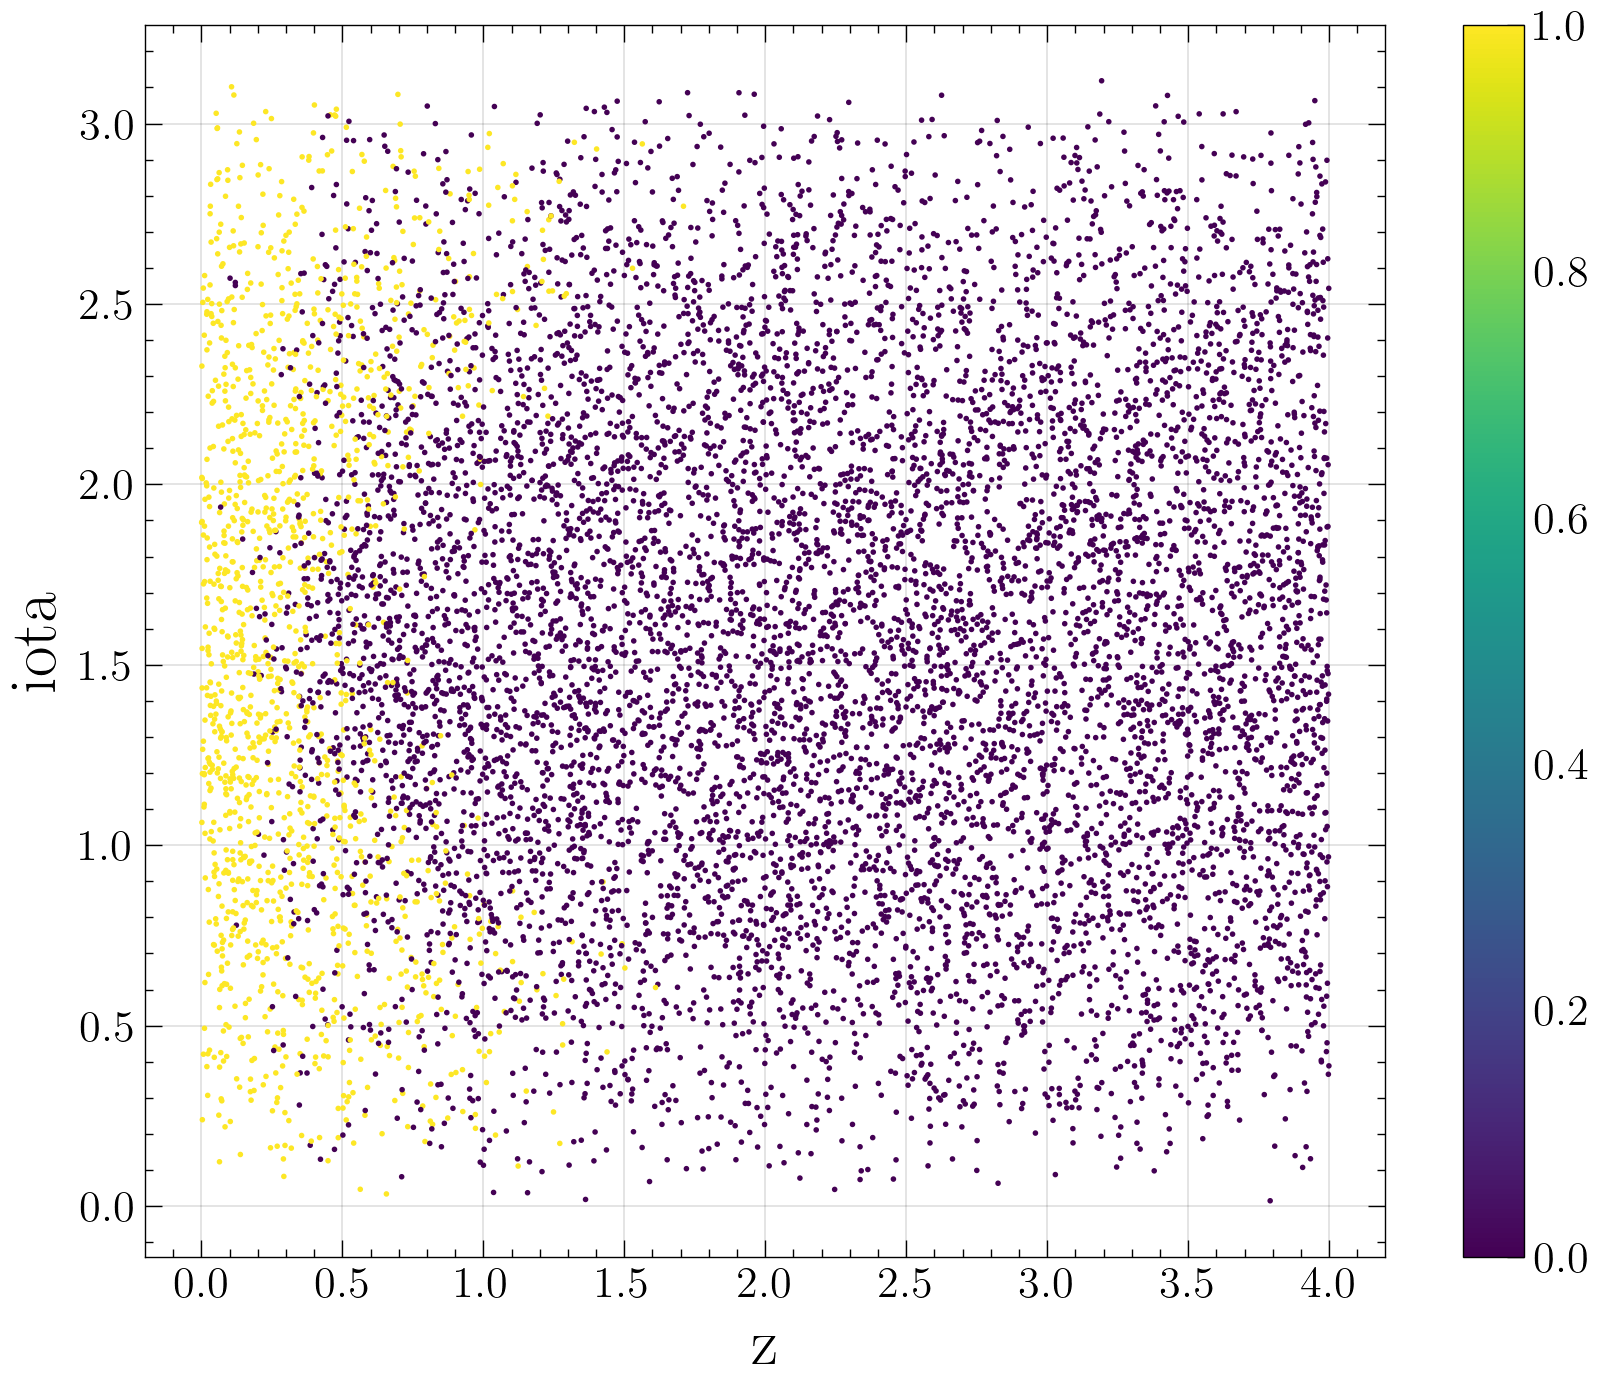

In [10]:
plt.scatter(data['z'], data['iota'], s=1, c=data['det'])
plt.xlabel('z')
plt.ylabel('iota')
plt.colorbar();

### 2.3) q(z)

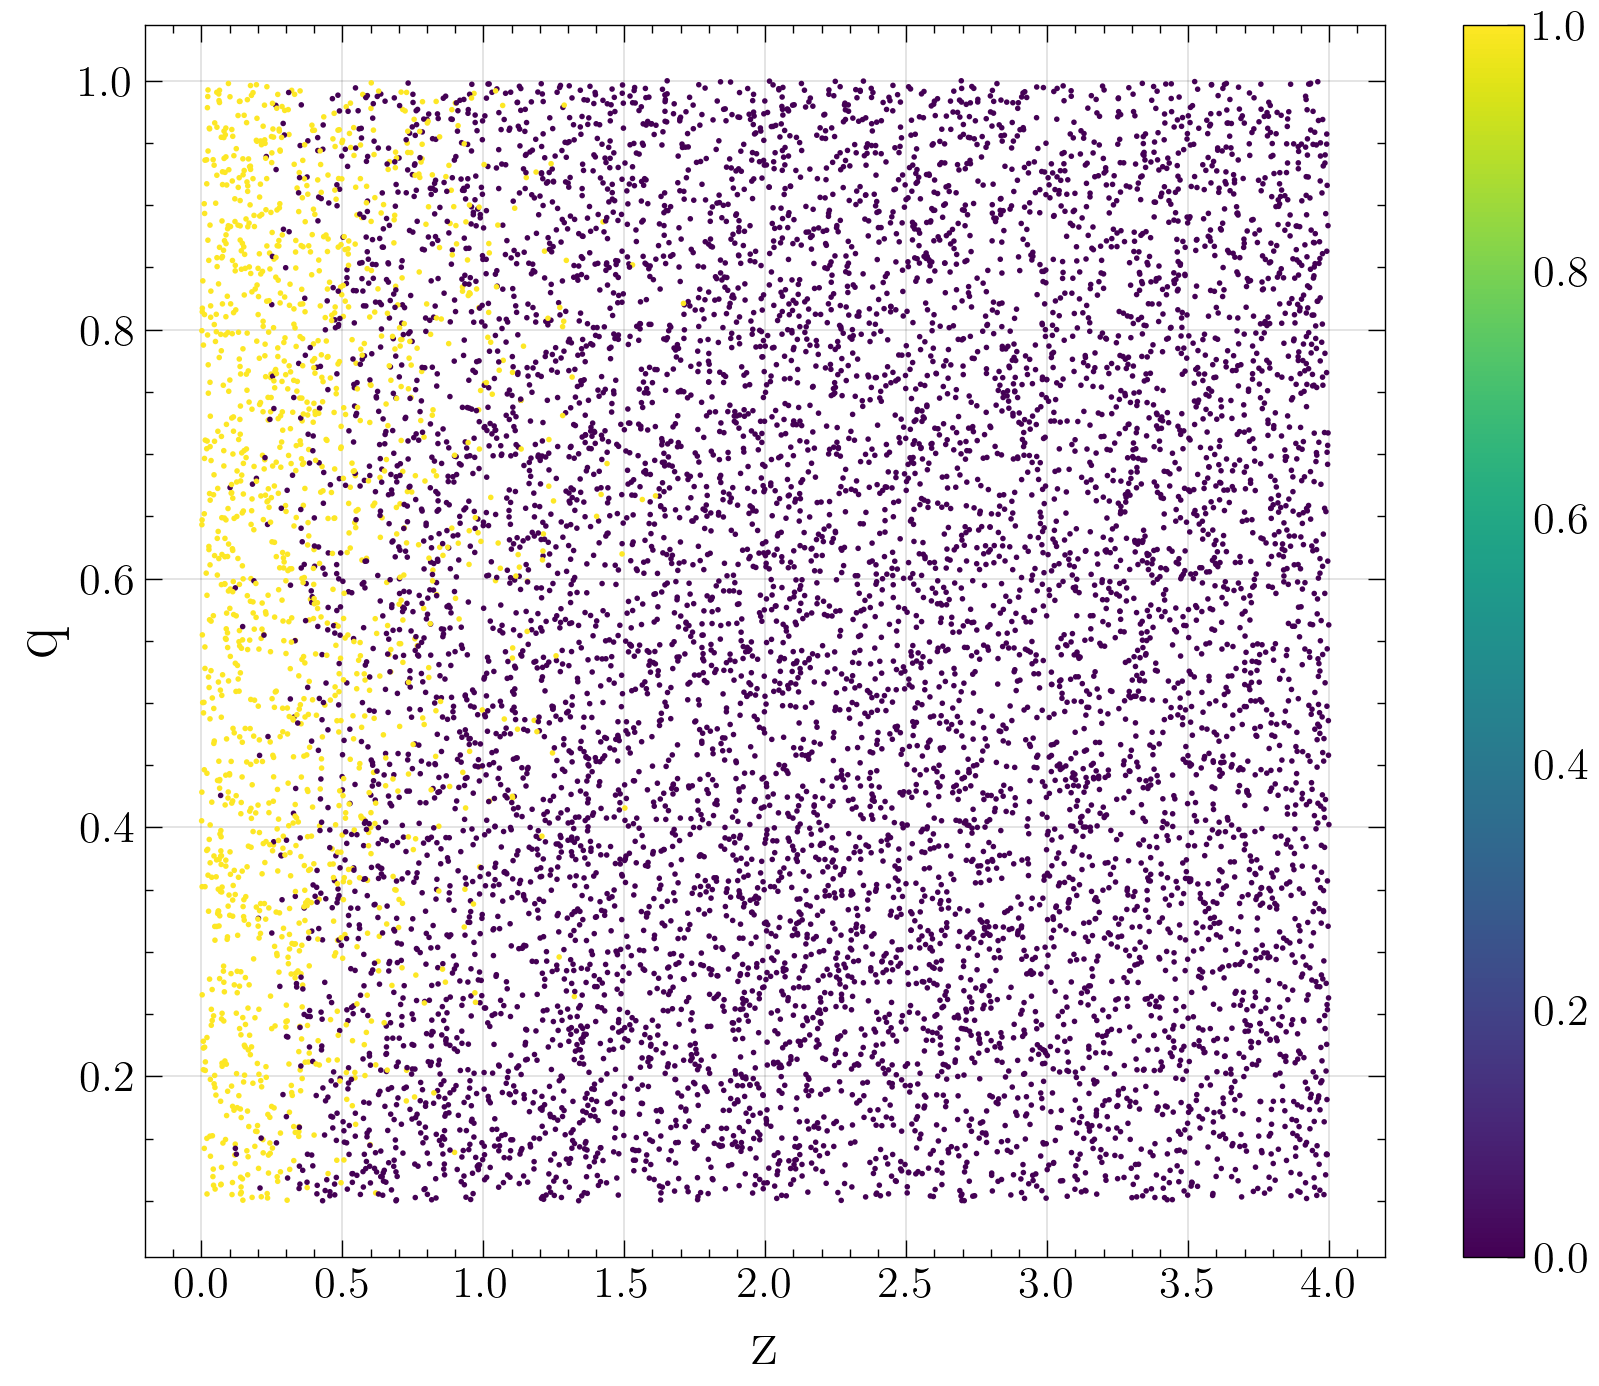

In [11]:
plt.scatter(data['z'], data['q'], s=1, c=data['det'])
plt.xlabel('z')
plt.ylabel('q')
plt.colorbar();

### 2.4) mtot(q)

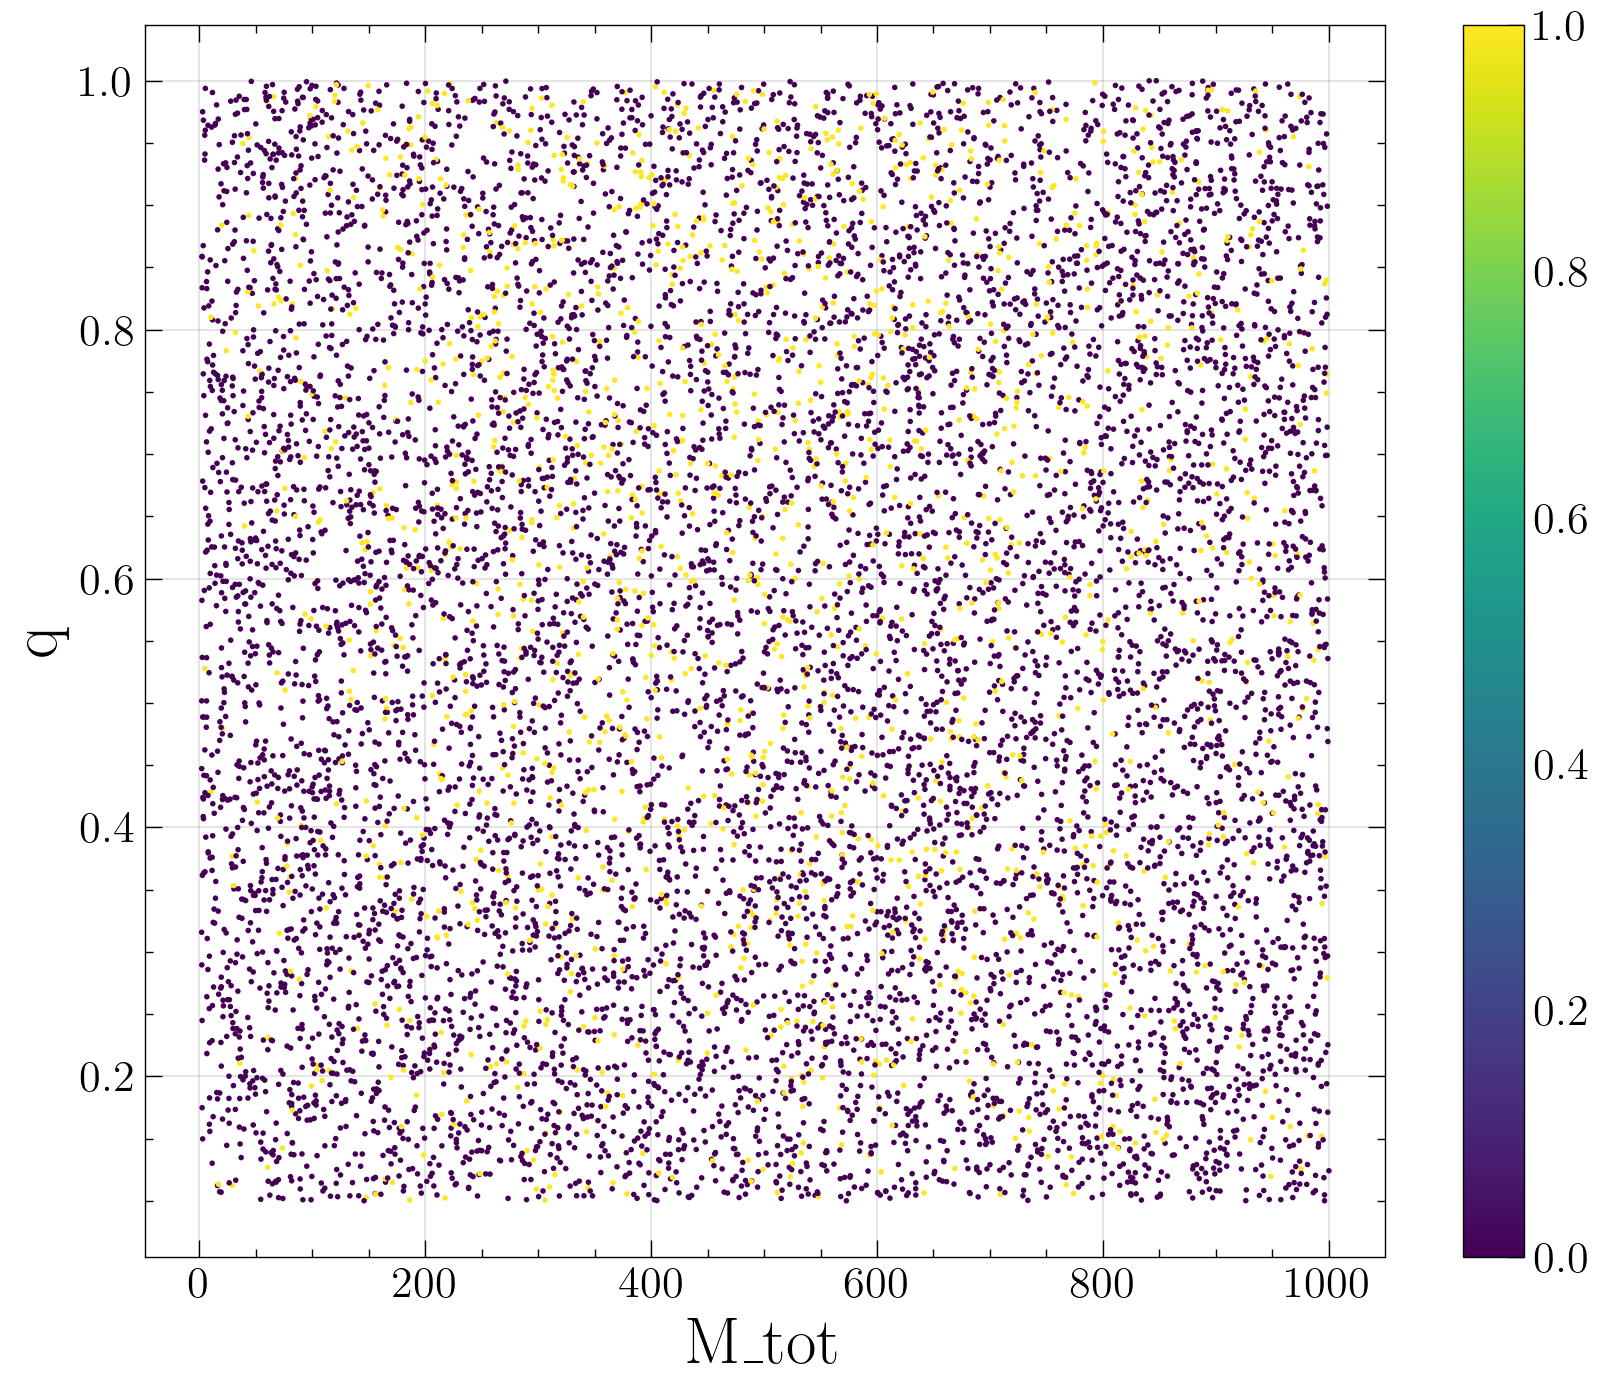

In [12]:
plt.scatter(data['mtot'], data['q'], s=1, c=data['det'])
plt.xlabel('M_tot')
plt.ylabel('q')
plt.colorbar();

## 3) Classification

In [13]:
def plot_svc_decision_function(clf, ax=None):
    """Plot the decision function for a 2D SVC"""
    if ax is None:
        ax = plt.gca()
    u = np.linspace(plt.xlim()[0], plt.xlim()[1], 30)
    v = np.linspace(plt.ylim()[0], plt.ylim()[1], 30)
    yy, xx = np.meshgrid(v, u)

    P = np.zeros_like(xx)
    for i, ui in enumerate(u):
        for j, vj in enumerate(v):
            Xgrid = np.array([ui, vj])
            P[i, j] = clf.decision_function(Xgrid.reshape(1,-1))[0]
    return ax.contour(xx, yy, P, colors='k',
                      levels=[-1, 0, 1], alpha=0.5,
                      linestyles=['--', '-', '--'])

In [23]:
svm = SVC(kernel='rbf', C=1.0,)
X = np.array([data['z'], np.log10(data['mtot'])]).T
%timeit svm.fit(X, data['det'])

748 ms ± 89.5 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


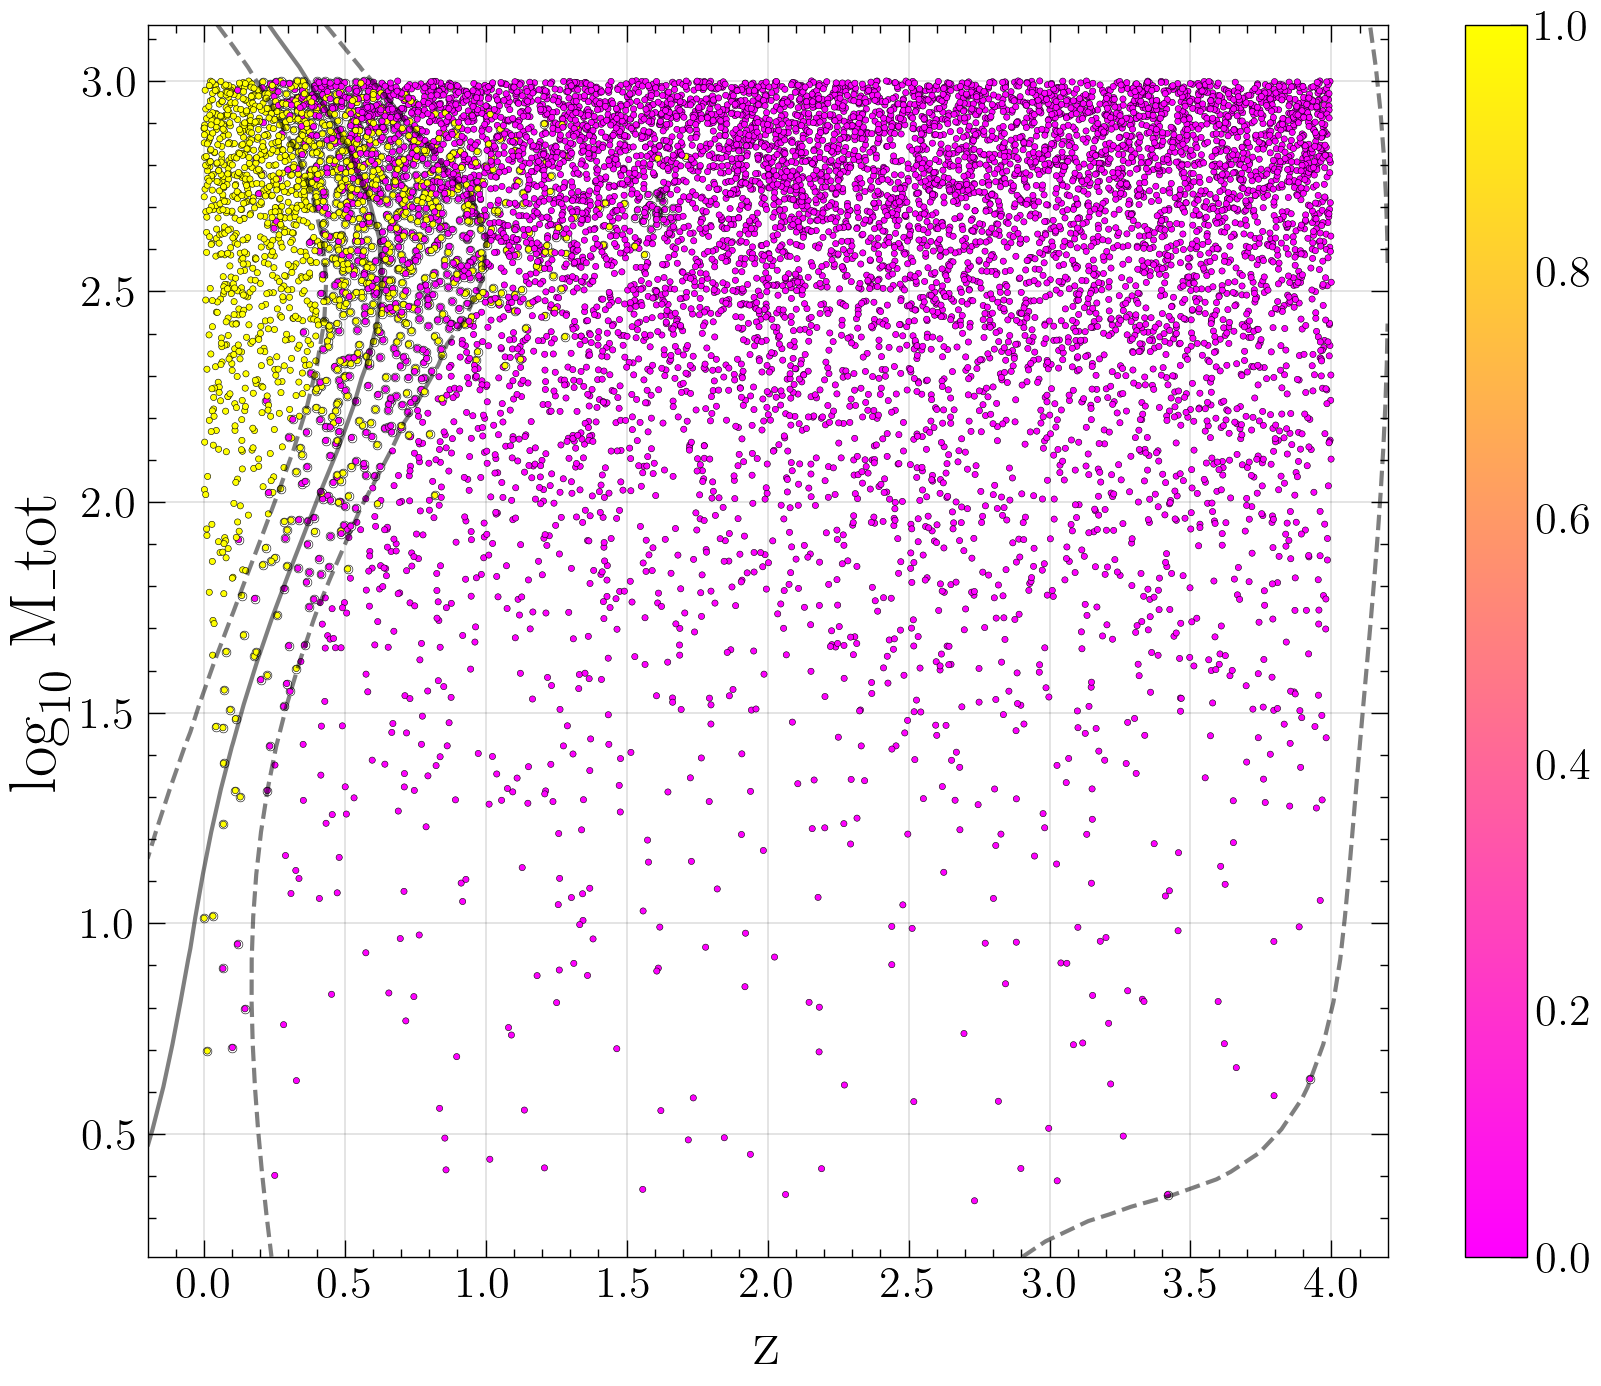

In [25]:
plt.scatter(svm.support_vectors_[:, 0], svm.support_vectors_[:, 1], s=10, linewidths=0.2, edgecolor='k', facecolor='w')
plt.scatter(X[:, 0], X[:, 1], c=data['det'], s=5, cmap='spring', linewidths=0.2, edgecolor='k')
plot_svc_decision_function(svm)
plt.xlabel('z')
plt.ylabel('$\log_{10}$ M_tot')
plt.colorbar();